In [1]:
import xarray as xr
import numpy as np
import os.path as op
import dask.array as da
from dask.diagnostics import ProgressBar
from xmitgcm import open_mdsdataset
from xgcm.grid import Grid
import matplotlib.colors as clrs
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ddir = '/swot/SUM05/takaya/MITgcm/channel/runs'

In [9]:
# 5054544*6e2/(360*86400)
# print((98*360*86400)/6e2+144)
# print((103*360*86400)/6e2+144)
ys, dy = (265,5)
ts = int((ys*360*86400)/6e2+144)
te = int(((ys+dy)*360*86400)/6e2+144)
print(ts,te)

13737744 13996944


In [10]:
ds = open_mdsdataset(op.join(ddir,'deepML-2mon_layersKPP'), grid_dir=op.join(ddir,'10km_grid'),
                     iters=range(ts,te,144),
                     prefix=['LAYERS-transport','KPPboundary'],
                     delta_t=6e2)
ds

/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:              (XC: 100, XG: 100, YC: 200, YG: 200, Z: 40, Zl: 40, Zp1: 41, Zu: 40, layer_1TH_bounds: 43, layer_1TH_center: 42, layer_1TH_interface: 41, time: 1800)
Coordinates:
  * XC                   (XC) >f4 5000.0 15000.0 25000.0 35000.0 45000.0 ...
  * YC                   (YC) >f4 5000.0 15000.0 25000.0 35000.0 45000.0 ...
  * XG                   (XG) >f4 0.0 10000.0 20000.0 30000.0 40000.0 ...
  * YG                   (YG) >f4 0.0 10000.0 20000.0 30000.0 40000.0 ...
  * Z                    (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 ...
  * Zp1                  (Zp1) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 ...
  * Zu                   (Zu) >f4 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 ...
  * Zl                   (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 ...
    rA                   (YC, XC) >f4 dask.array<shape=(200, 100), chunksize=(200, 100)>
    dxG                  (YG, XC) >f4 dask.array<shape=(200, 100), chunksize=(200, 100)>


In [11]:
grid = Grid(ds, periodic=['X'])
grid

<xgcm.Grid>
Z Axis (not periodic):
  * center   Z (40) --> left
  * left     Zl (40) --> center
  * outer    Zp1 (41) --> center
  * right    Zu (40) --> center
T Axis (not periodic):
  * center   time (1800)
1TH Axis (not periodic):
  * center   layer_1TH_center (42) --> outer
  * outer    layer_1TH_bounds (43) --> center
  * inner    layer_1TH_interface (41) --> center
Y Axis (not periodic):
  * center   YC (200) --> left
  * left     YG (200) --> center
X Axis (periodic):
  * center   XC (100) --> left
  * left     XG (100) --> center

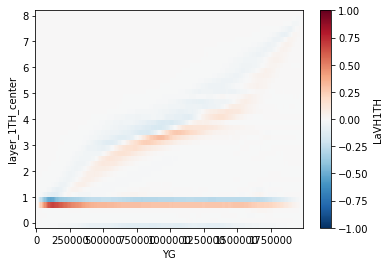

In [8]:
ds.LaVH1TH.mean(['time','XC']).plot(vmax=1e0)

In [9]:
with ProgressBar():
    psi_clim = -grid.cumsum((ds.LaVH1TH.mean('time')*ds.dxG).sum('XC'),
                           '1TH', boundary='fill'
                           ).rename('psi').compute()
psi_clim

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed | 10.2s


<xarray.DataArray 'psi' (layer_1TH_bounds: 43, YG: 200)>
array([[-0.000000e+00, -0.000000e+00, -0.000000e+00, ..., -0.000000e+00,
        -0.000000e+00, -0.000000e+00],
       [-0.000000e+00, -0.000000e+00, -1.312801e+03, ...,  3.871031e+02,
         1.520490e+01, -9.447197e+02],
       [-0.000000e+00, -0.000000e+00, -1.228506e+03, ...,  8.832006e+02,
         1.572012e+03,  5.655621e+01],
       ...,
       [-0.000000e+00, -0.000000e+00, -4.935516e+00, ..., -1.233435e+04,
        -1.177643e+04, -6.105655e+03],
       [-0.000000e+00, -0.000000e+00, -4.935516e+00, ..., -1.762695e+00,
        -1.101562e+00, -5.068359e-01],
       [-0.000000e+00, -0.000000e+00, -4.935516e+00, ..., -1.762695e+00,
        -1.101562e+00, -5.068359e-01]], dtype=float32)
Coordinates:
  * layer_1TH_bounds  (layer_1TH_bounds) >f4 -0.2 0.0 0.2 0.4 0.6 0.8 1.0 ...
  * YG                (YG) >f4 0.0 10000.0 20000.0 30000.0 40000.0 50000.0 ...

In [82]:
seas = np.tile(np.repeat(range(1,5),90),dy)
LaVH_rolled = ds.LaVH1TH.roll(time=-30)
LaVH_rolled.coords['season'] = ('time',seas)
LaVH1TH_seas = LaVH_rolled.groupby('season').mean('time')

with ProgressBar():
    psi_seas = -grid.cumsum((LaVH1TH_seas*ds.dxG).sum('XC'),
                           '1TH', boundary='fill'
                           ).rename('psi').compute()
psi_seas

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  7.2s


<xarray.DataArray 'psi' (season: 4, layer_1TH_bounds: 43, YG: 200)>
array([[[  -0.     ,   -0.     , ...,   -0.     ,   -0.     ],
        [  -0.     ,   -0.     , ..., 1196.438  , -251.28787],
        ...,
        [  -0.     ,   -0.     , ..., -670.4453 , -335.07275],
        [  -0.     ,   -0.     , ..., -670.4453 , -335.07275]],

       [[  -0.     ,   -0.     , ...,   -0.     ,   -0.     ],
        [  -0.     ,   -0.     , ..., 2822.6807 ,  826.8074 ],
        ...,
        [  -0.     ,   -0.     , ...,  620.541  ,  310.1582 ],
        [  -0.     ,   -0.     , ...,  620.541  ,  310.1582 ]],

       [[  -0.     ,   -0.     , ...,   -0.     ,   -0.     ],
        [  -0.     ,   -0.     , ..., 2496.0405 , 1238.3433 ],
        ...,
        [  -0.     ,   -0.     , ..., -662.0215 , -330.89062],
        [  -0.     ,   -0.     , ..., -662.0215 , -330.89062]],

       [[  -0.     ,   -0.     , ...,   -0.     ,   -0.     ],
        [  -0.     ,   -0.     , ..., -389.48193, -896.4321 ],
     

In [10]:
vname = 'LaHs1TH' 
mean_thkns = ds[vname].mean(['time','XC'])
mean_thkns[::-1]

<xarray.DataArray 'LaHs1TH' (layer_1TH_center: 42, YG: 200)>
dask.array<shape=(42, 200), dtype=float32, chunksize=(42, 200)>
Coordinates:
  * YG                (YG) >f4 0.0 10000.0 20000.0 30000.0 40000.0 50000.0 ...
  * layer_1TH_center  (layer_1TH_center) float32 8.1 7.9 7.7 7.5 7.3 7.1 6.9 ...

[########################################] | 100% Completed |  1min 55.9s
[########################################] | 100% Completed |  4.3s


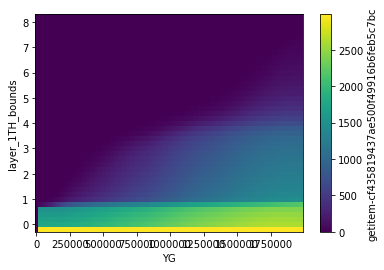

In [11]:
zb = xr.DataArray(grid.cumsum(mean_thkns[::-1], '1TH', boundary='fill')[::-1].data,
                 dims=['layer_1TH_bounds','YG'],
                 coords={'layer_1TH_bounds':ds.layer_1TH_bounds,'YG':ds.YG}
                 )
with ProgressBar():
    zb.plot()

In [12]:
def get_layer_depths(ds, dim, layers_name='1TH', point='s'):
    lprefix = 'layer_' + layers_name
    vname = 'LaH' + point + layers_name
    mn_thkns = ds[vname].mean(['time','XC'])
    
    # this represents the depth of the layers1TH_bounds points
    # (used as the boundaries of the center values)
    zb = xr.DataArray(grid.cumsum(mean_thkns[::-1], '1TH', boundary='fill')[::-1].data,
                     dims=['layer_1TH_bounds','YG'],
                     coords={'layer_1TH_bounds':ds.layer_1TH_bounds,'YG':ds.YG}
                     )
    
    # and this is the depth of the layers1TH_center points
    # (used as the boundaries of the interface values)
    zc = grid.interp(zb,'1TH',boundary='fill')
    
    # the interface depths
    zi = zb[1:-1].rename({lprefix+'_bounds': lprefix+'_interface'})
    
    z= {lprefix + '_bounds': zb,
        lprefix + '_center': zc,
        lprefix + '_interface': zi}
    return z[dim]

In [13]:
z = -get_layer_depths(ds, psi_clim.dims[0], layers_name='1TH').values
y = np.tile(ds.YC.values[np.newaxis,:], (z.shape[0],1))

In [14]:
with ProgressBar():
    MLD_clim = ds.MXLDEPTH.mean(['time','XC']).compute()

[########################################] | 100% Completed |  3.1s


In [21]:
ds.LaPs1TH.attrs

OrderedDict([('standard_name', 'LaPs1TH'),
             ('long_name', 'Layer Probability at V points [-]'),
             ('units', '1'),
             ('mate', 'LaPw1TH')])

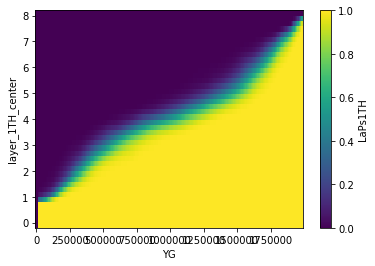

In [22]:
ds.LaPs1TH.mean(['time','XC']).plot()

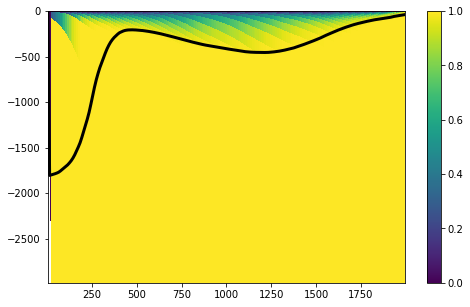

In [54]:
fig, ax = plt.subplots(figsize=(8,5))
im = ax.pcolormesh(y*1e-3, z, ds.LaPs1TH.mean(['time','XC']))
ax.plot(MLD_clim.YC*1e-3, -MLD_clim, color='k', lw=3)
fig.colorbar(im, ax=ax)

In [13]:
days = np.tile(np.repeat(range(12),30),5)
MLD = ds.MXLDEPTH
hbl = ds.KPPhbl
MLD.coords['DinM'] = ('time',days)
with ProgressBar():
    MLD_mon = MLD.groupby('DinM').mean(['time','XC']).compute()
#     hbl_mon = hbl.groupby('day').mean('time').compute()
# hbl_mon
hbl

[########################################] | 100% Completed |  2.9s


<xarray.DataArray 'KPPhbl' (time: 1800, YC: 200, XC: 100)>
dask.array<shape=(1800, 200, 100), dtype=float32, chunksize=(1, 200, 100)>
Coordinates:
  * XC       (XC) >f4 5000.0 15000.0 25000.0 35000.0 45000.0 55000.0 65000.0 ...
  * YC       (YC) >f4 5000.0 15000.0 25000.0 35000.0 45000.0 55000.0 65000.0 ...
    rA       (YC, XC) >f4 dask.array<shape=(200, 100), chunksize=(200, 100)>
    Depth    (YC, XC) >f4 dask.array<shape=(200, 100), chunksize=(200, 100)>
    iter     (time) int64 dask.array<shape=(1800,), chunksize=(1,)>
  * time     (time) float64 8.243e+09 8.243e+09 8.243e+09 8.243e+09 ...
Attributes:
    standard_name:  KPPhbl
    long_name:      KPP boundary layer depth, bulk Ri criterion
    units:          m

In [14]:
MLD.to_netcdf(op.join(ddir,'MLD_10km_zonalave.nc'))

In [15]:
hbl99 = xr.DataArray(np.percentile(hbl, 99, axis=-1), dims=['time','YC'],
                    coords={'time':ds.time,'YC':ds.YC})
hbl99

<xarray.DataArray (time: 1800, YC: 200)>
array([[   0.      , 1492.563938, 1452.659446, ...,   30.      ,   30.      ,
          30.      ],
       [   0.      , 1491.300111, 1472.123698, ...,   30.      ,   30.      ,
          30.      ],
       [   0.      , 1497.555848, 1479.397247, ...,   30.      ,   30.      ,
          30.      ],
       ...,
       [   0.      , 1505.80401 , 1504.961573, ...,   30.      ,   30.      ,
          30.      ],
       [   0.      , 1512.749624, 1508.118376, ...,   30.      ,   30.      ,
          30.      ],
       [   0.      , 1519.536272, 1509.934318, ...,   30.      ,   30.      ,
          30.      ]])
Coordinates:
  * time     (time) float64 8.243e+09 8.243e+09 8.243e+09 8.243e+09 ...
  * YC       (YC) >f4 5000.0 15000.0 25000.0 35000.0 45000.0 55000.0 65000.0 ...

In [16]:
seasons = np.tile(np.repeat(range(4),90),5)
hbl99.coords['DinM'] = ('time',days)
hbl99.to_netcdf(op.join(ddir,'MXLD_10km_zonalave.nc'))
# with ProgressBar():
#     hbl99_seas = hbl99.groupby('season').mean('time').compute()
# hbl99_seas

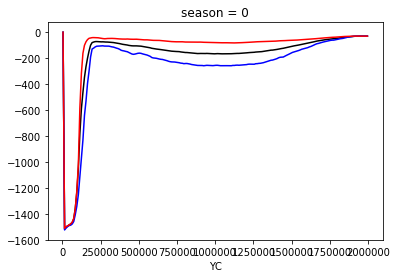

In [40]:
(-hbl99).mean('time').plot(color='k')
(-hbl99_seas)[2].plot(color='b')
(-hbl99_seas)[0].plot(color='r')

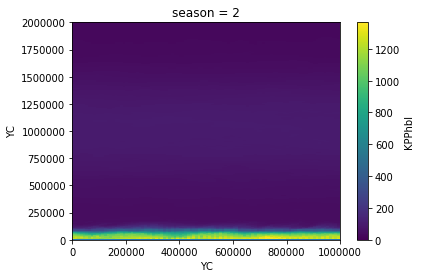

In [35]:
hbl.mean(['time']).plot()


Text(0,0.5,'MLD [m]')

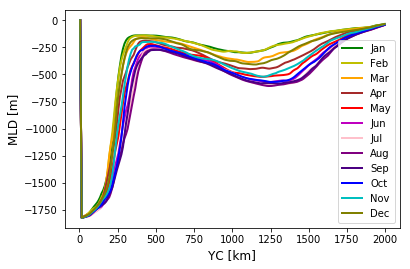

In [17]:
colors = ['g','y','orange','brown','r','m','pink','purple','indigo','b','c','olive']
month = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, ax = plt.subplots(figsize=(6,4))
for i in range(12):
    ax.plot(MLD_mon.YC*1e-3, -MLD_mon[i], lw=2, color=colors[i], label=month[i])
ax.legend(loc='lower right', fontsize=10)
ax.set_xlabel(r'YC [km]', fontsize=12)
ax.set_ylabel(r'MLD [m]', fontsize=12)
# plt.savefig(op.join(ddir,'MLD_month-clim.pdf'))

In [18]:
dsT = open_mdsdataset(op.join(ddir,'zerores_-2monDML_Ttave'), grid_dir=op.join(ddir,'10km_grid'),
                      iters=range(ts-144+4320,te,4320),
                      prefix=['Ttave'], delta_t=6e2
                      )
dsT_clim = dsT.mean(['time','XC'])
with ProgressBar():
    dsT_clim.load()
Ttave = dsT.Ttave.mean('XC')
seasons = np.tile(np.repeat(range(4),3),5)
Ttave.coords['season'] = ('time',seasons)
with ProgressBar():
    T_seas = Ttave.groupby('season').mean('time').compute()
T_seas

/home/takaya/xmitgcm/xmitgcm/mds_store.py:721: UserWarning: Couldn't find available_diagnostics.log in /swot/SUM05/takaya/MITgcm/channel/runs/zerores_-2monDML_Ttave. Using default version.
  "in %s. Using default version." % data_dir)
/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)


[                                        ] | 0% Completed |  0.0s

/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  0.2s


<xarray.DataArray 'Ttave' (season: 4, Z: 40, YC: 200)>
array([[[ 0.      ,  0.702402, ...,  7.839471,  7.893518],
        [ 0.      ,  0.761393, ...,  7.42347 ,  7.421808],
        ...,
        [ 0.      , -0.588036, ..., -0.539315, -0.54273 ],
        [ 0.      , -0.588238, ..., -0.574569, -0.574838]],

       [[ 0.      ,  0.693033, ...,  7.751986,  7.837573],
        [ 0.      ,  0.749462, ...,  7.434752,  7.453975],
        ...,
        [ 0.      , -0.587997, ..., -0.539585, -0.54262 ],
        [ 0.      , -0.58819 , ..., -0.574426, -0.574741]],

       [[ 0.      ,  0.688216, ...,  7.737066,  7.826485],
        [ 0.      ,  0.737263, ...,  7.4024  ,  7.423094],
        ...,
        [ 0.      , -0.587908, ..., -0.539234, -0.542575],
        [ 0.      , -0.588087, ..., -0.574312, -0.57467 ]],

       [[ 0.      ,  0.689081, ...,  7.822844,  7.879476],
        [ 0.      ,  0.733424, ...,  7.370452,  7.381559],
        ...,
        [ 0.      , -0.587759, ..., -0.538911, -0.542275],
  

In [19]:
alpha = 2e-4
g = 9.81
N2 = alpha*g * grid.interp(grid.diff(dsT_clim.Ttave, 'Z', boundary='fill')
                           / grid.diff(dsT_clim.Z, 'Z', boundary='fill'), 
                           'Z', boundary='fill')
N2_seas = alpha*g * grid.interp(grid.diff(T_seas, 'Z', boundary='fill')
                               / grid.diff(T_seas.Z, 'Z', boundary='fill'), 
                               'Z', boundary='fill')
N2_seas

<xarray.DataArray (season: 4, Z: 40, YC: 200)>
array([[[-0.000000e+00, -1.435983e-04, ..., -1.497295e-03, -1.502434e-03],
        [-0.000000e+00, -6.870964e-06, ...,  5.750797e-05,  6.365504e-05],
        ...,
        [-0.000000e+00,  6.968973e-09, ...,  1.917300e-06,  1.854453e-06],
        [ 0.000000e+00,  1.922769e-09, ...,  3.357721e-07,  3.058128e-07]],

       [[-0.000000e+00, -1.415088e-04, ..., -1.489819e-03, -1.500101e-03],
        [-0.000000e+00, -6.599741e-06, ...,  4.633718e-05,  5.420285e-05],
        ...,
        [-0.000000e+00,  6.881549e-09, ...,  1.908832e-06,  1.854841e-06],
        [ 0.000000e+00,  1.834209e-09, ...,  3.318391e-07,  3.059320e-07]],

       [[-0.000000e+00, -1.398395e-04, ..., -1.485182e-03, -1.495984e-03],
        [-0.000000e+00, -5.763454e-06, ...,  4.706279e-05,  5.478752e-05],
        ...,
        [-0.000000e+00,  6.651066e-09, ...,  1.916810e-06,  1.859082e-06],
        [ 0.000000e+00,  1.705911e-09, ...,  3.340917e-07,  3.056754e-07]],

       [

Text(0.48,0.01,'Y [km]')

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


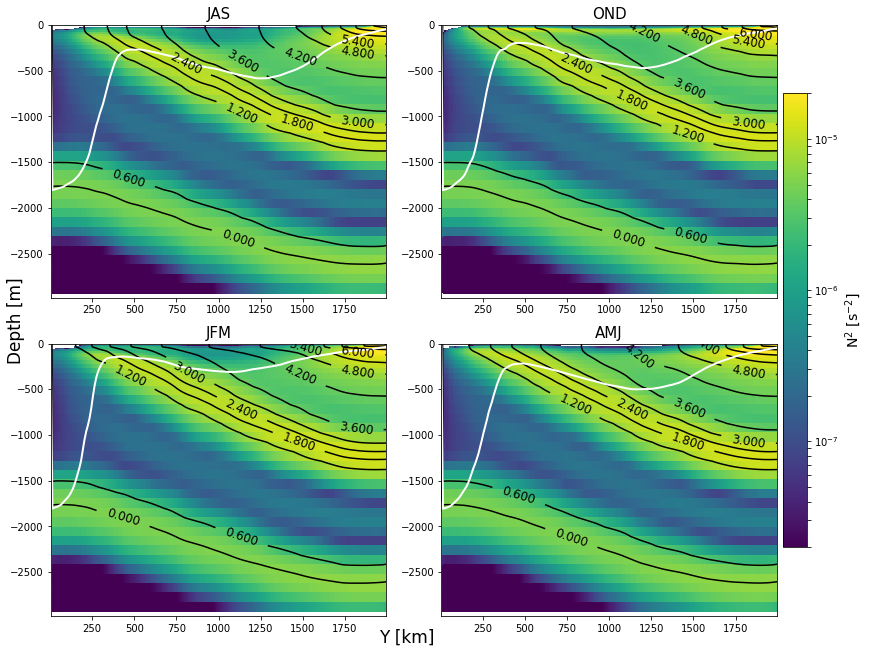

In [59]:
MLD.coords['seas'] = ('time',np.tile(np.repeat(range(4),90),dy))
MLD_seas = MLD.groupby('seas').mean(['time'])

fig, axes = plt.subplots(ncols=2,nrows=2,figsize=(11,9))
fig.set_tight_layout(True)
im = axes[0,0].pcolormesh(T_seas.YC*1e-3, T_seas.Z.data, 
                         N2_seas[2],
                         norm=clrs.LogNorm(), vmin=2e-8, vmax=2e-5, rasterized=True)
cm1 = axes[0,0].contour(T_seas.YC*1e-3, T_seas.Z, T_seas[2], 15, colors='k')
axes[0,0].plot(T_seas.YC*1e-3, -MLD_seas[2], 'w', lw=2)
axes[0,1].pcolormesh(T_seas.YC*1e-3, T_seas.Z.data, 
                    N2_seas[-1],
                    norm=clrs.LogNorm(), vmin=2e-8, vmax=2e-5, rasterized=True)
cm2 = axes[0,1].contour(T_seas.YC*1e-3, T_seas.Z, T_seas[-1], 15, colors='k')
axes[0,1].plot(T_seas.YC*1e-3, -MLD_seas[-1], 'w', lw=2)
axes[1,0].pcolormesh(T_seas.YC*1e-3, T_seas.Z.data, 
                    N2_seas[2],
                    norm=clrs.LogNorm(), vmin=2e-8, vmax=2e-5, rasterized=True)
cm3 = axes[1,0].contour(T_seas.YC*1e-3, T_seas.Z, T_seas[0], 15, colors='k')
axes[1,0].plot(T_seas.YC*1e-3, -MLD_seas[0], 'w', lw=2)
axes[1,1].pcolormesh(T_seas.YC*1e-3, T_seas.Z.data, 
                    N2_seas[1],
                    norm=clrs.LogNorm(), vmin=2e-8, vmax=2e-5, rasterized=True)
cm4 = axes[1,1].contour(T_seas.YC*1e-3, T_seas.Z, T_seas[1], 15, colors='k')
axes[1,1].plot(T_seas.YC*1e-3, -MLD_seas[1], 'w', lw=2)

axes[0,0].set_title(r"JAS", fontsize=15)
axes[0,1].set_title(r"OND", fontsize=15)
axes[1,0].set_title(r"JFM", fontsize=15)
axes[1,1].set_title(r"AMJ", fontsize=15)
# axes[0,0].set_xticklabels([])
# axes[0,1].set_xticklabels([])
# axes[0,1].set_yticklabels([])
# axes[1,1].set_yticklabels([])
axes[0,0].set_ylim([ds.Zp1.min(),0.])
axes[0,1].set_ylim([ds.Zp1.min(),0])
axes[1,0].set_ylim([ds.Zp1.min(),0])
axes[1,1].set_ylim([ds.Zp1.min(),0])
plt.clabel(cm1, inline=1, fontsize=12)
plt.clabel(cm2, inline=1, fontsize=12)
plt.clabel(cm3, inline=1, fontsize=12)
plt.clabel(cm4, inline=1, fontsize=12)
# ax.set_title(r'N$^2$ w/ temperature contour')
cbar_ax = fig.add_axes([0.99, 0.15, 0.03, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'N$^2$ [s$^{-2}$]', fontsize=14)

# fig.subplots_adjust(right=0.8, bottom=0.2)
fig.text(0.01, 0.5, 'Depth [m]', 
         va='center', rotation='vertical', fontsize=17)
fig.text(0.48, 0.01, 'Y [km]', 
         va='center', rotation='horizontal', fontsize=17)

# plt.savefig(op.join(ddir,'LocaldeepML_seasonal-stratification.pdf'))

In [31]:
dsT

<xarray.Dataset>
Dimensions:  (XC: 100, XG: 100, YC: 200, YG: 200, Z: 40, Zl: 40, Zp1: 41, Zu: 40, time: 60)
Coordinates:
  * XC       (XC) >f4 5000.0 15000.0 25000.0 35000.0 45000.0 55000.0 65000.0 ...
  * YC       (YC) >f4 5000.0 15000.0 25000.0 35000.0 45000.0 55000.0 65000.0 ...
  * XG       (XG) >f4 0.0 10000.0 20000.0 30000.0 40000.0 50000.0 60000.0 ...
  * YG       (YG) >f4 0.0 10000.0 20000.0 30000.0 40000.0 50000.0 60000.0 ...
  * Z        (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 -126.0 ...
  * Zp1      (Zp1) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * Zu       (Zu) >f4 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * Zl       (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
    rA       (YC, XC) >f4 dask.array<shape=(200, 100), chunksize=(200, 100)>
    dxG      (YG, XC) >f4 dask.array<shape=(200, 100), chunksize=(200, 100)>
    dyG      (YC, XG) >f4 10000.0 10000.0 10000.0 10000.0 10000.0 10000.0 ...
    Depth    (

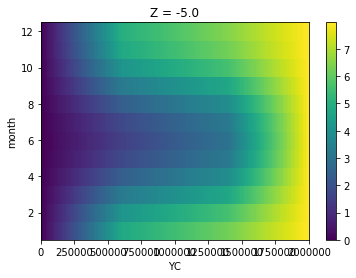

In [20]:
dtype = '>f8'
shape = (12,40,200,100)
Trelax = np.fromfile(op.join(ddir,'zerores_-2monDML_Ttave/rbcs_SSTandNB-relax_zero-res_-2mon_010km.bin'), 
                    dtype=dtype)
Trelax.shape = shape
Trelax = xr.DataArray(Trelax, dims=['month','Z','YC','XC'],
                     coords={'month':range(1,13),'Z':ds.Z.data,'YC':ds.YC.data,'XC':ds.XC.data}
                     )
Trelax[:,0].mean('XC').plot()

In [21]:
cp = 3994.  #[J kg-1 K-1]
rho0 = 999.8  #[kg m-3]
tau = 3e1*86400  #[s]
C = rho0*cp*ds.drF[0]*ds.hFacC[0]*tau**-1
sst = dsT.Ttave[:,0]
Q = xr.DataArray(np.zeros_like(sst), dims=sst.dims,
                coords=sst.coords)

for i in range(5):
    for j in range(12):
        Q[i*12+j] = (-sst[i*12+j] + Trelax[j,0]) * C
        
Q

<xarray.DataArray (time: 60, YC: 200, XC: 100)>
array([[[  0.      ,   0.      , ...,   0.      ,   0.      ],
        [-10.437984,  -9.733244, ..., -10.376649,  -9.817837],
        ...,
        [  4.395341,   4.73437 , ...,   3.615891,   4.007181],
        [  1.955429,   2.118402, ...,   1.711635,   1.807913]],

       [[  0.      ,   0.      , ...,   0.      ,   0.      ],
        [-10.744072, -10.26463 , ..., -10.650415, -10.164408],
        ...,
        [  4.890509,   4.790668, ...,   4.87736 ,   4.91957 ],
        [  3.155115,   3.192301, ...,   2.930288,   3.068365]],

       ...,

       [[  0.      ,   0.      , ...,   0.      ,   0.      ],
        [ -9.130052,  -8.848352, ...,  -9.528638,  -8.934626],
        ...,
        [  0.62756 ,   0.646087, ...,   0.556296,   0.600424],
        [  0.860855,   0.782942, ...,   0.960673,   0.921004]],

       [[  0.      ,   0.      , ...,   0.      ,   0.      ],
        [ -9.205859,  -8.685431, ...,  -9.818984,  -8.914748],
        ...,

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


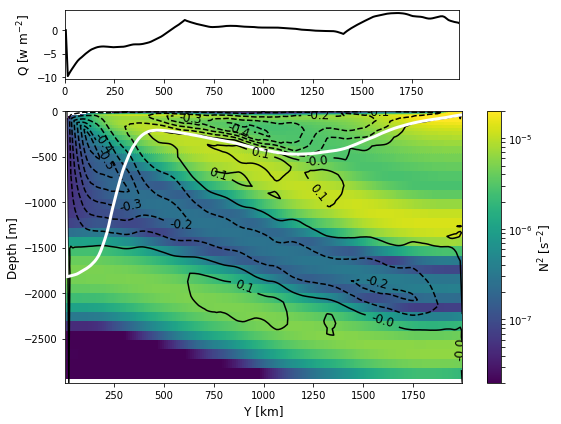

In [22]:
psilevs = np.arange(-.8,.9,0.1) + 0.

fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot2grid((4,5),(0,0),colspan=4)
ax2 = plt.subplot2grid((4,5),(1,0),rowspan=3, colspan=5)
fig.set_tight_layout(True)
ax1.plot(dsT_clim.YC*1e-3, Q.mean(['time','XC']), 'k', lw=2)
ax1.set_xlim([0,1990.])
ax1.set_ylabel(r"Q [w m$^{-2}$]", fontsize=12)
im = ax2.pcolormesh(dsT_clim.YC*1e-3, dsT_clim.Z.data, N2,
                   norm=clrs.LogNorm(), vmin=2e-8, vmax=2e-5, rasterized=True)
ct = ax2.contour(y*1e-3, z, psi_clim*1e-6,
                colors='k', levels=psilevs, extend='both')
ax2.plot(MLD_clim.YC*1e-3, -MLD_clim, color='white', lw=3)
ax2.set_xlabel(r'Y [km]', fontsize=12)
ax2.set_ylabel(r'Depth [m]', fontsize=12)
plt.clabel(ct, inline=1, fmt='%1.1f', fontsize=12)
cbar = fig.colorbar(im, ax=ax2)
cbar.set_label(r'N$^2$ [s$^{-2}$]', fontsize=12)
plt.savefig(op.join(ddir,'Figures/DeeplocalML_10km_overturning.pdf'))

In [1]:
fig, ax = plt.subplots()
ax.pcolormesh(y*1e-3,z,ds.LaPs1TH.mean(['time','XC']))

NameError: name 'plt' is not defined